In [51]:
from urllib.error import HTTPError
import pandas as pd

In [13]:
df = pd.read_html('https://wind.nrel.gov/MetData/135mData/M5Twr/20Hz/mat/2015/06/03/')[0]

In [17]:
df = df[['Name', 'Last modified', 'Size']]
df = df.dropna(how='all')
df = df.query('Name != "Parent Directory"').reset_index(drop=True)
df

,Name,Last modified,Size
0,06_03_2015_00_00_00_000.mat,27-Jul-2018 17:21,2.1M
1,06_03_2015_00_10_00_000.mat,27-Jul-2018 17:22,2.1M
2,06_03_2015_00_20_00_000.mat,27-Jul-2018 17:22,2.0M
3,06_03_2015_00_30_00_000.mat,27-Jul-2018 17:23,2.1M
4,06_03_2015_00_40_00_000.mat,27-Jul-2018 17:23,2.0M
...,...,...,...
139,06_03_2015_23_20_00_000.mat,27-Jul-2018 18:45,2.2M
140,06_03_2015_23_30_00_000.mat,27-Jul-2018 18:45,2.1M
141,06_03_2015_23_40_00_000.mat,27-Jul-2018 18:46,2.3M
142,06_03_2015_23_50_00_000.mat,27-Jul-2018 18:46,2.2M


In [22]:
days = pd.date_range(start='2012-08-31', end='2020-05-09', freq='D')
days

DatetimeIndex(['2012-08-31', '2012-09-01', '2012-09-02', '2012-09-03',
               '2012-09-04', '2012-09-05', '2012-09-06', '2012-09-07',
               '2012-09-08', '2012-09-09',
               ...
               '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-09'],
              dtype='datetime64[ns]', length=2809, freq='D')

In [23]:
days[:10]

DatetimeIndex(['2012-08-31', '2012-09-01', '2012-09-02', '2012-09-03',
               '2012-09-04', '2012-09-05', '2012-09-06', '2012-09-07',
               '2012-09-08', '2012-09-09'],
              dtype='datetime64[ns]', freq='D')

In [30]:
days[1].strftime('%Y/%m/%d/')

'2012/09/01/'

In [4]:
df = pd.DataFrame({'name': ['09_09_2012_23_10_00_043.mat',
                            'Corrupted_09_09_2012_23_20_00_043.mat',
                            '09_09_2012_23_30_00_043.mat']
                  }
                 )

In [5]:
df

,name
0,09_09_2012_23_10_00_043.mat
1,Corrupted_09_09_2012_23_20_00_043.mat
2,09_09_2012_23_30_00_043.mat


In [10]:
test = df['Name'].str.extract(r'^(\d{2}_\d{2}_\d{4}_\d{2}_\d{2}_\d{2})_\d{3}.mat')
test

,0
0,09_09_2012_23_10_00
1,NaN
2,09_09_2012_23_30_00


In [16]:
pd.to_datetime(test[0], format='%m_%d_%Y_%H_%M_%S')

0   2012-09-09 23:10:00
1                   NaT
2   2012-09-09 23:30:00
Name: 0, dtype: datetime64[ns]

In [31]:
def fetch_and_process_table(url):
    df = pd.read_html(url)[0]
    df = df[['Name', 'Last modified', 'Size']]
    df = df.dropna(how='all')
    return df.query('Name != "Parent Directory"').reset_index(drop=True)

In [62]:
BASE_URL = 'https://wind.nrel.gov/MetData/135mData/M5Twr/20Hz/mat/'
def scrape_table(start_date, end_date):
    days = pd.date_range(start=start_date, end=end_date, freq='D')
    out = []
    for day in days:
        url = BASE_URL + day.strftime('%Y/%m/%d/')
        try:
            result = fetch_and_process_table(url)
        except HTTPError:
            continue
        out.append(result)
    return out

In [63]:
lst = scrape_table('2012-08-30', '2013-08-30')

In [64]:
df = pd.concat(lst, ignore_index=True)

In [57]:
df['mult'] = df['Size'].str[-1].replace({'M': 2**10, 'K': 1})
df['Size_kb'] = (df['Size'].str[:-1].astype(np.float32) * df['mult']).round().astype(np.int32)

<ipython-input-57-32392c5dffd3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mult'] = df['Size'].str[-1].replace({'M': 2**10, 'K': 1})


In [58]:
df = df[['Name', 'Last modified', 'Size_kb']]
df

,Name,Last modified,Size_kb
0,08_31_2012_00_00_00_011.mat,16-Jan-2015 13:37,4915
1,08_31_2012_00_10_00_011.mat,16-Jan-2015 13:39,4608
2,08_31_2012_00_20_00_011.mat,16-Jan-2015 13:41,4813
3,08_31_2012_00_30_00_011.mat,16-Jan-2015 13:43,4710
4,08_31_2012_00_40_00_011.mat,16-Jan-2015 13:45,5018
...,...,...,...
1434,09_09_2012_23_10_00_043.mat,18-Jan-2015 00:58,4403
1435,09_09_2012_23_20_00_043.mat,18-Jan-2015 00:59,4710
1436,09_09_2012_23_30_00_043.mat,18-Jan-2015 01:01,4608
1437,09_09_2012_23_40_00_043.mat,18-Jan-2015 01:02,4506


In [157]:
def post_process(list_of_df):
    df = pd.concat(lst, ignore_index=True)
    df['mult'] = df['Size'].str[-1].replace({'M': 2**10, 'K': 1})
    df['size'] = (df['Size'].str[:-1].astype(np.float32) * df['mult']).round().astype(np.int32)
    date_str = df['Name'].str.extract(r'^(\d{2}_\d{2}_\d{4}_\d{2}_\d{2}_\d{2})_\d{3}.mat')
    df['timestamp'] = pd.to_datetime(date_str[0], format='%m_%d_%Y_%H_%M_%S')
    return df[['timestamp', 'Name', 'size']]

In [66]:
df = post_process(lst)

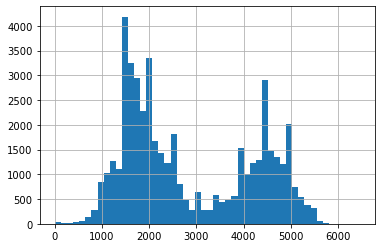

In [67]:
df['size'].hist(bins=50)

In [68]:
df.shape

(47896, 2)

In [69]:
df.head()

,timestamp,size
0,2012-08-31 00:00:00,4915
1,2012-08-31 00:10:00,4608
2,2012-08-31 00:20:00,4813
3,2012-08-31 00:30:00,4710
4,2012-08-31 00:40:00,5018


In [72]:
df = df.set_index(df['timestamp'])

In [73]:
df['doy'] = df.index.dayofyear
df['year'] = df.index.year

In [75]:
df['size'].resample('MS').count()

timestamp
2012-08-01     146
2012-09-01    4254
2012-10-01    4440
2012-11-01    4147
2012-12-01    4446
2013-01-01    4422
2013-02-01    4031
2013-03-01    4459
2013-04-01    4198
2013-05-01    4323
2013-06-01    2522
2013-07-01    3492
2013-08-01    3014
Name: size, dtype: int64

In [77]:
df[['size']].to_parquet('up_to_2013-8-31.parquet')

In [78]:
pd.read_parquet('up_to_2013-8-31.parquet')

,size
timestamp,
2012-08-31 00:00:00,4915
2012-08-31 00:10:00,4608
2012-08-31 00:20:00,4813
2012-08-31 00:30:00,4710
2012-08-31 00:40:00,5018
...,...
2013-08-30 23:10:00,2458
2013-08-30 23:20:00,2048
2013-08-30 23:30:00,1536


In [86]:
from IPython.display import Audio
import numpy as np

In [87]:
start = pd.Timestamp('now')
lst = scrape_table('2013-08-31', '2020-05-09')
end  = pd.Timestamp('now')

In [88]:
end - start

Timedelta('0 days 03:05:41.578782')

In [89]:
Audio(np.sin(np.linspace(0, 12000, 80000)), rate=20000, autoplay=True)

In [158]:
df = post_process(lst)

In [159]:
df = df.set_index(df['timestamp'])

In [92]:
df[['size']].to_parquet('after_2013-8-30.parquet')

In [160]:
df.head()

,timestamp,Name,size
timestamp,,,
2013-08-31 00:00:00,2013-08-31 00:00:00,08_31_2013_00_00_00_016.mat,1434
2013-08-31 00:10:00,2013-08-31 00:10:00,08_31_2013_00_10_00_016.mat,1536
2013-08-31 00:20:00,2013-08-31 00:20:00,08_31_2013_00_20_00_016.mat,1536
2013-08-31 00:30:00,2013-08-31 00:30:00,08_31_2013_00_30_00_016.mat,1946
2013-08-31 00:40:00,2013-08-31 00:40:00,08_31_2013_00_40_00_016.mat,1536


In [161]:
df[['Name', 'size']].to_parquet('after_2013-8-30_with_names.parquet')

In [93]:
df2 = pd.read_parquet('./up_to_2013-8-31.parquet')

In [103]:
df = pd.concat([pd.read_parquet('./up_to_2013-8-31.parquet'), pd.read_parquet('./after_2013-8-30.parquet')], ignore_index=False)

In [104]:
df.describe()

,size
count,348327.000000
mean,3189.912436
std,1093.657511
min,1.000000
25%,2355.000000
50%,3482.000000
75%,4096.000000
max,6451.000000


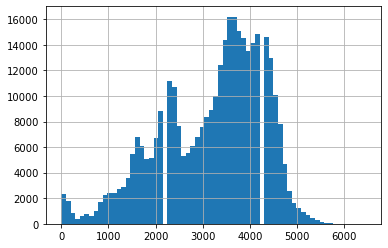

In [105]:
df['size'].hist(bins=66)

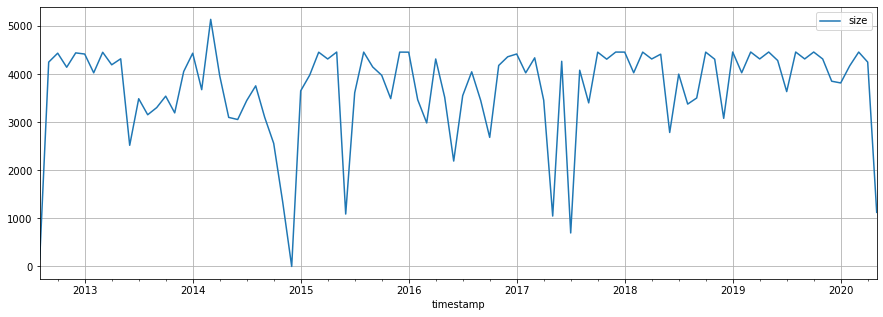

In [108]:
df.resample('MS').count().plot(figsize=(15,5), grid=True)

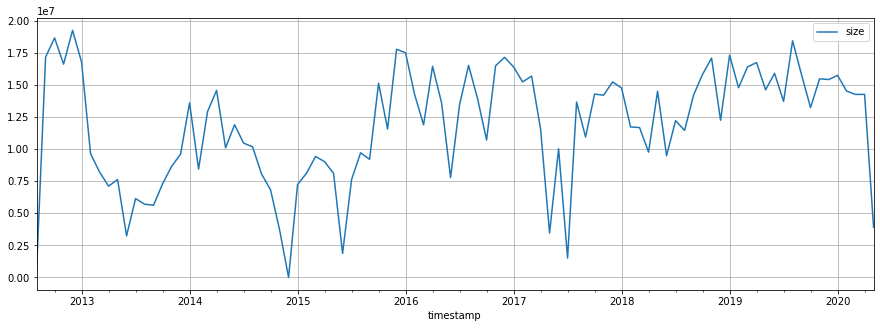

In [109]:
df.resample('MS').sum().plot(figsize=(15,5), grid=True)

In [112]:
df.sum() / 2**20 # yields GBs

size    1059.65865
dtype: float64

In [113]:
df['2019'].sum() / 2**20

size    179.147923
dtype: float64

In [115]:
test = pd.DatetimeIndex(pd.date_range('2019-1-1', '2019-12-31', freq='D'))

In [128]:
n = 24
stride = int(round(test.shape[0]/n))
test[::stride]

DatetimeIndex(['2019-01-01', '2019-01-16', '2019-01-31', '2019-02-15',
               '2019-03-02', '2019-03-17', '2019-04-01', '2019-04-16',
               '2019-05-01', '2019-05-16', '2019-05-31', '2019-06-15',
               '2019-06-30', '2019-07-15', '2019-07-30', '2019-08-14',
               '2019-08-29', '2019-09-13', '2019-09-28', '2019-10-13',
               '2019-10-28', '2019-11-12', '2019-11-27', '2019-12-12',
               '2019-12-27'],
              dtype='datetime64[ns]', freq='15D')

In [142]:
n=18
pd.Timestamp('2019-1-1') + pd.Timedelta('10min') * pd.Series(np.round(np.arange(n) * 144/n))

0    2019-01-01 00:00:00
1    2019-01-01 01:20:00
2    2019-01-01 02:40:00
3    2019-01-01 04:00:00
4    2019-01-01 05:20:00
5    2019-01-01 06:40:00
6    2019-01-01 08:00:00
7    2019-01-01 09:20:00
8    2019-01-01 10:40:00
9    2019-01-01 12:00:00
10   2019-01-01 13:20:00
11   2019-01-01 14:40:00
12   2019-01-01 16:00:00
13   2019-01-01 17:20:00
14   2019-01-01 18:40:00
15   2019-01-01 20:00:00
16   2019-01-01 21:20:00
17   2019-01-01 22:40:00
dtype: datetime64[ns]

In [154]:
def time_sampler(start_date: pd.Timestamp, samples_per_day: int, samples_per_year: int, num_years: int=1) -> pd.Series:
    days = start_date + pd.Timedelta('1D') * pd.Series(np.round(np.arange(samples_per_year * num_years) * 365.25/samples_per_year))
    times = pd.Timedelta('10min') * pd.Series(np.round(np.arange(samples_per_day) * 144/samples_per_day))
    return pd.concat([times + day for day in days], ignore_index=True)

In [162]:
test = time_sampler(pd.Timestamp('2019-1-1'), samples_per_day=4, samples_per_year=2, num_years=2)
test

0    2019-01-01 00:00:00
1    2019-01-01 06:00:00
2    2019-01-01 12:00:00
3    2019-01-01 18:00:00
4    2019-07-03 00:00:00
5    2019-07-03 06:00:00
6    2019-07-03 12:00:00
7    2019-07-03 18:00:00
8    2020-01-01 00:00:00
9    2020-01-01 06:00:00
10   2020-01-01 12:00:00
11   2020-01-01 18:00:00
12   2020-07-02 00:00:00
13   2020-07-02 06:00:00
14   2020-07-02 12:00:00
15   2020-07-02 18:00:00
dtype: datetime64[ns]

In [165]:
test = pd.DataFrame(test)

In [169]:
test['url_date'] = test[0].dt.strftime('%Y/%m/%d/')
test['filename'] = test[0].dt.strftime('%m_%d_%Y_%H_%M_%S_000.mat')
test

,0,url_date,filename
0,2019-01-01 00:00:00,2019/01/01/,01_01_2019_00_00_00_000.mat
1,2019-01-01 06:00:00,2019/01/01/,01_01_2019_06_00_00_000.mat
2,2019-01-01 12:00:00,2019/01/01/,01_01_2019_12_00_00_000.mat
3,2019-01-01 18:00:00,2019/01/01/,01_01_2019_18_00_00_000.mat
4,2019-07-03 00:00:00,2019/07/03/,07_03_2019_00_00_00_000.mat
5,2019-07-03 06:00:00,2019/07/03/,07_03_2019_06_00_00_000.mat
6,2019-07-03 12:00:00,2019/07/03/,07_03_2019_12_00_00_000.mat
7,2019-07-03 18:00:00,2019/07/03/,07_03_2019_18_00_00_000.mat
8,2020-01-01 00:00:00,2020/01/01/,01_01_2020_00_00_00_000.mat
9,2020-01-01 06:00:00,2020/01/01/,01_01_2020_06_00_00_000.mat


In [170]:
list(test[['url_date', 'filename']].itertuples(index=False, name=None))

[('2019/01/01/', '01_01_2019_00_00_00_000.mat'),
 ('2019/01/01/', '01_01_2019_06_00_00_000.mat'),
 ('2019/01/01/', '01_01_2019_12_00_00_000.mat'),
 ('2019/01/01/', '01_01_2019_18_00_00_000.mat'),
 ('2019/07/03/', '07_03_2019_00_00_00_000.mat'),
 ('2019/07/03/', '07_03_2019_06_00_00_000.mat'),
 ('2019/07/03/', '07_03_2019_12_00_00_000.mat'),
 ('2019/07/03/', '07_03_2019_18_00_00_000.mat'),
 ('2020/01/01/', '01_01_2020_00_00_00_000.mat'),
 ('2020/01/01/', '01_01_2020_06_00_00_000.mat'),
 ('2020/01/01/', '01_01_2020_12_00_00_000.mat'),
 ('2020/01/01/', '01_01_2020_18_00_00_000.mat'),
 ('2020/07/02/', '07_02_2020_00_00_00_000.mat'),
 ('2020/07/02/', '07_02_2020_06_00_00_000.mat'),
 ('2020/07/02/', '07_02_2020_12_00_00_000.mat'),
 ('2020/07/02/', '07_02_2020_18_00_00_000.mat')]

In [175]:
pd.Timestamp('now').strftime('%H:%M:%S')

'15:10:31'